In [1]:
from SAXSsimulations import  Sphere, Cylinder
from SAXSsimulations.plotting import *

In [2]:
simulation = Sphere(size = 10, nPoints = 501, volFrac = 0.05)
simulation.place_shape()

volume fraction is 0.00214, radius is 0.99, center at (0.6,-1.7,-2.5) 
volume fraction is 0.00325, radius is 0.99, center at (0.7,-2.0,-2.4) 
volume fraction is 0.00524, radius is 0.99, center at (3.4,0.0,3.0) 
volume fraction is 0.00794, radius is 0.99, center at (2.1,3.6,3.5) 
volume fraction is 0.01177, radius is 0.99, center at (-3.2,1.1,-0.7) 
volume fraction is 0.01695, radius is 0.99, center at (-1.8,-1.3,2.3) 
volume fraction is 0.01902, radius is 0.99, center at (3.3,0.2,0.6) 
volume fraction is 0.02178, radius is 0.99, center at (-0.1,-4.0,-1.4) 
volume fraction is 0.02469, radius is 0.99, center at (-3.5,-1.1,3.3) 
volume fraction is 0.02810, radius is 0.99, center at (1.2,1.5,2.0) 
volume fraction is 0.03179, radius is 0.99, center at (1.6,1.6,0.8) 
volume fraction is 0.03515, radius is 0.99, center at (4.0,-3.6,3.0) 
volume fraction is 0.04005, radius is 0.99, center at (-3.0,1.1,3.0) 
volume fraction is 0.04240, radius is 0.99, center at (-1.7,0.6,-2.7) 
volume fraction i

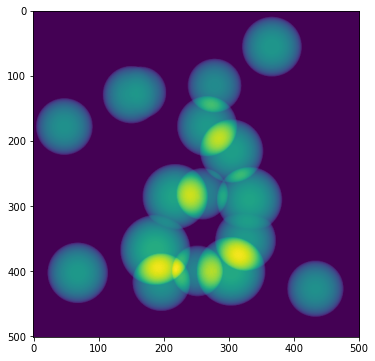

In [3]:
plt.figure(figsize=(6,6))
plt.imshow(simulation.density.sum(axis=0))

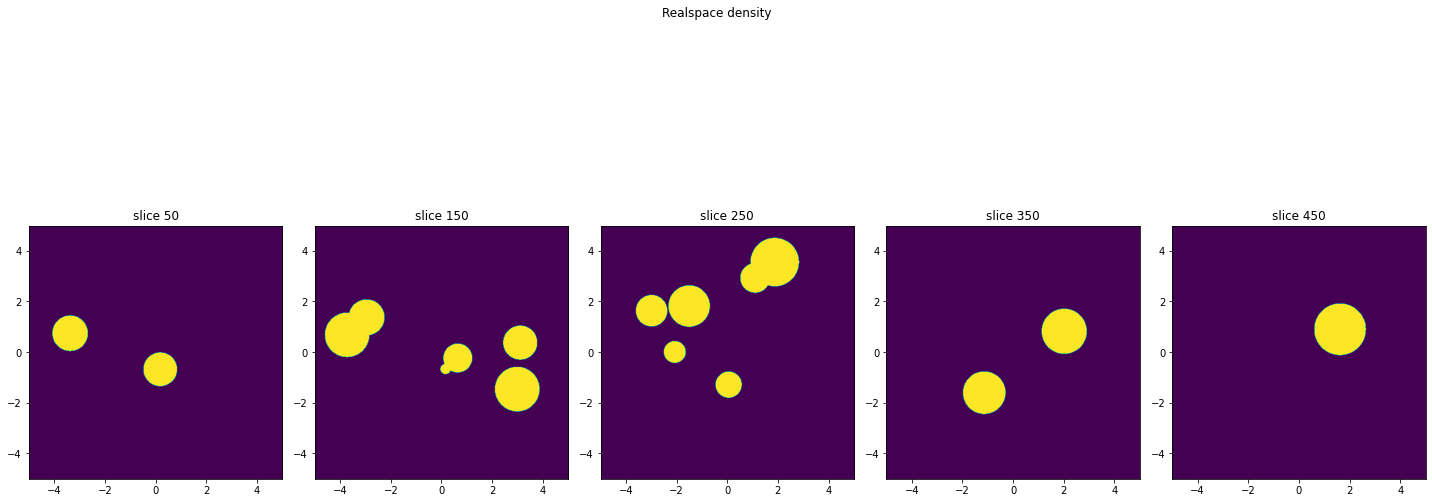

In [3]:
plot_slices(simulation.density, simulation.grid)

In [4]:
#plot_3D_structure(simulation.density, simulation.grid, realspace=True)

In [4]:
simulation.calculate_custom_FTI_3D(device = 'cpu')
simulation.calculate_custom_FTI_3D_slice(device = 'cpu')
simulation.calculate_torch_FTI_3D(device = 'cpu')
simulation.sinc()

/home/slaskina/SAXS-simulations/SAXSsimulations/create_form.py:92: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352657443/work/aten/src/ATen/native/Copy.cpp:250.)
  if FT[k,:,:].any():


the maximal difference between the implementation of the FTI is 0.00965864211320877


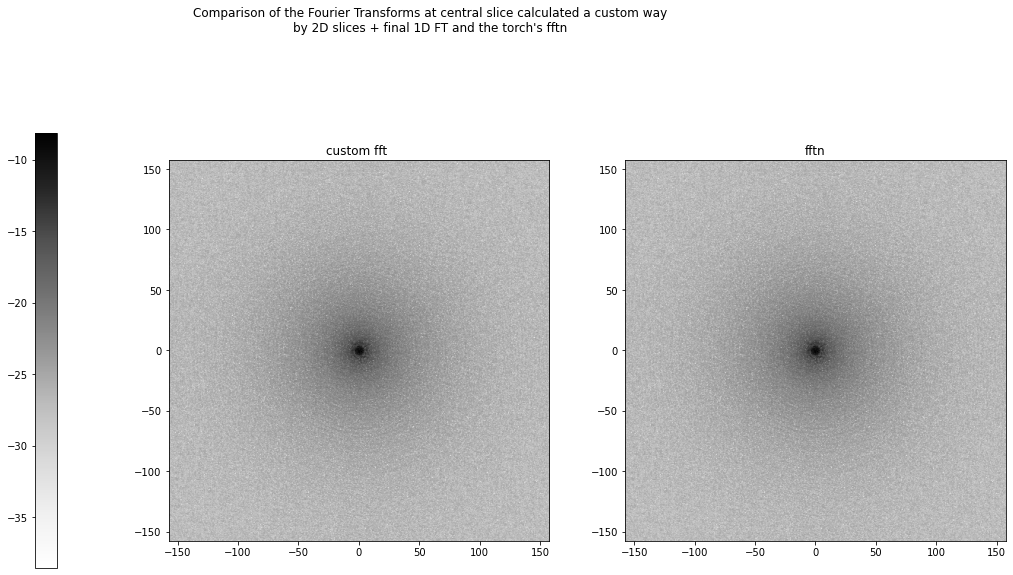

In [5]:
plot_FTI_version_center(simulation.FTI_slice_custom, simulation.FTI_slice_torch, simulation.qx)

the maximal difference between the implementation of the FTI is 0.02568071521818638


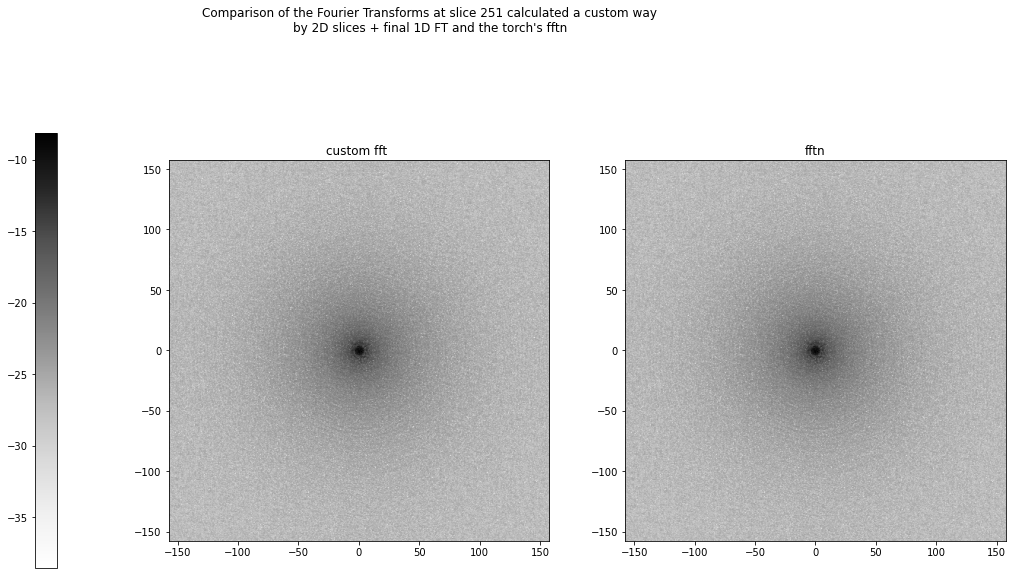

In [6]:
plot_FTI_version(simulation.FTI_custom, simulation.FTI_torch, simulation.qx,slice_number = 251)

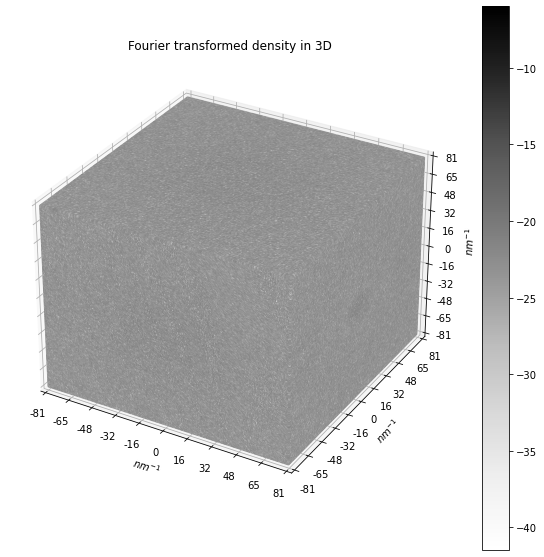

In [19]:
import torch
#plot_3D_structure(torch.from_numpy(simulation.FTI), simulation.qx, realspace= False)#, path = 'figures/FFT_spheres_example.png')

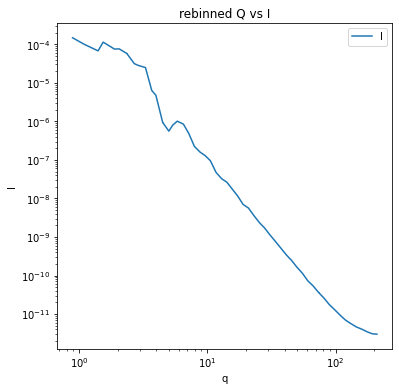

In [8]:
#simulation.reBin(200, slice = 'center')
#simulation.drop_first_bin()
plot_Q_vs_I(simulation.binned_slice)

In [10]:
simulation.init_sas_model()

AttributeError: 'Sphere' object has no attribute 'binned_data'

In [38]:
simulation.init_sas_model()
simulation.update_scaling(6.5566e-06)
plot_simulation_vs_sas( simulation.binned_data, simulation.qx_sas, simulation.I_sas)

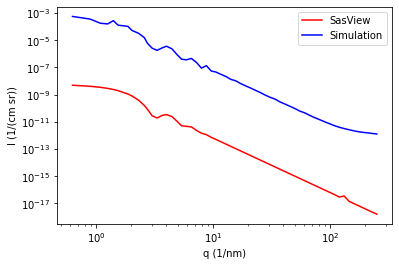

In [39]:
plot_simulation_vs_sas( simulation.binned_data, simulation.qx_sas, simulation.I_sas)

In [6]:
simulation.save_data(directory='dat_files')
print("the sphere file with radius {r:.3f}  is saved".format(r = simulation.rMean))

AttributeError: 'Cylinder' object has no attribute 'binned_data'

In [4]:
from SAXSsimulations import  Sphere, Cylinder
from SAXSsimulations.plotting import *

simulation = Cylinder(size = 10, nPoints = 251, volFrac = 0.05)
simulation.place_shape(single = True, rMean = 0.8)
print(simulation.theta, simulation.phi,simulation.grid_space)

A: (0.92,1.98), C: (5.84,1.18) 0.048227787017822266 0.23595267534255981
Ellipse equation: (x-(+0.12))^2/0.84^2 +(y -(+1.18))^2/1.03^2<1, line equation: y < -0.16x+2.13
A: (3.25,-2.97), C: (4.71,-2.03)
Ellipse equation: (x-(+4.00))^2/0.84^2 +(y -(-2.03))^2/1.03^2<1, line equation: y > 0.64x-5.06
A: (3.21,0.86), C: (4.52,1.71)
Ellipse equation: (x-(+4.04))^2/0.84^2 +(y -(+1.71))^2/1.03^2<1, line equation: y > 0.64x-1.20
A: (3.25,-1.42), C: (-2.42,-2.22) 0.04495459794998169 0.23267948627471924
Ellipse equation: (x-(+2.45))^2/0.84^2 +(y -(-2.22))^2/1.03^2<1, line equation: y < 0.14x-1.88
A: (4.51,2.07), C: (3.68,1.55)
Ellipse equation: (x-(+3.98))^2/0.84^2 +(y -(+1.55))^2/1.03^2<1, line equation: y > 0.64x-0.82
A: (1.94,-2.63), C: (-5.36,-2.06) 1.420050024986267 1.6077749729156494
Ellipse equation: (x-(+2.52))^2/0.84^2 +(y -(-2.06))^2/1.03^2<1, line equation: y < -0.08x-2.48
A: (4.25,1.83), C: (3.85,1.58)
Ellipse equation: (x-(+3.99))^2/0.84^2 +(y -(+1.58))^2/1.03^2<1, line equation: y > 0

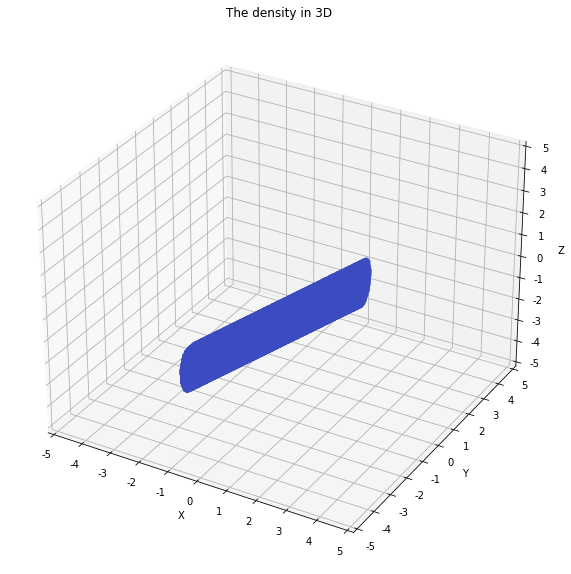

In [11]:
plot_3D_structure(simulation.density, simulation.grid, realspace=True)

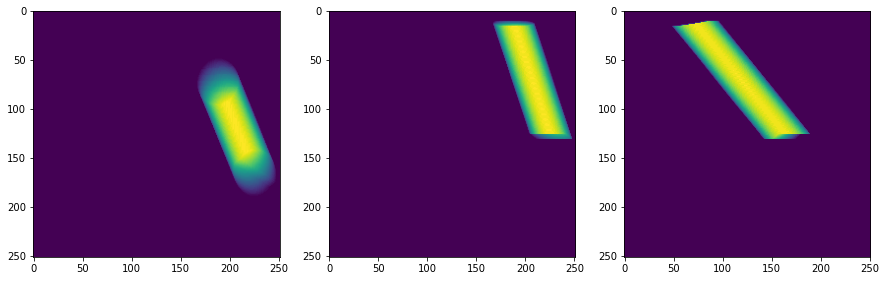

In [5]:
#plot_slices(simulation.density, simulation.grid, direction ='z')
plt_slices_sum(simulation)

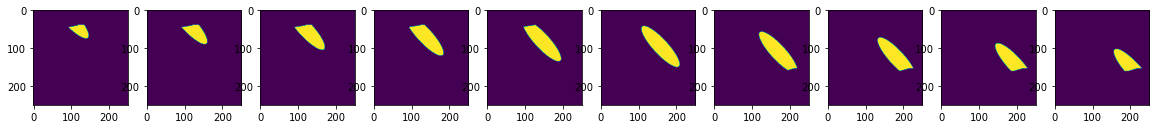

In [7]:
plot_slices_at_interval(6, 100, simulation, 'z')

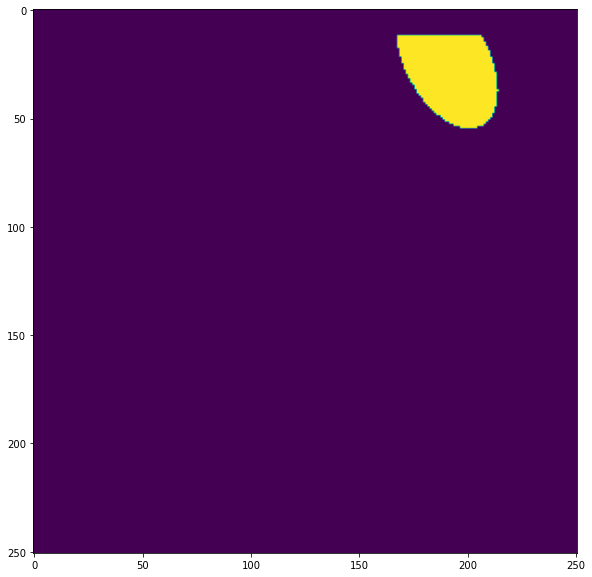

In [7]:
plt.figure(figsize = (10,10))
plt.imshow(simulation.density.sum(axis=2))
#plt.imshow(simulation.density[:,80,:])

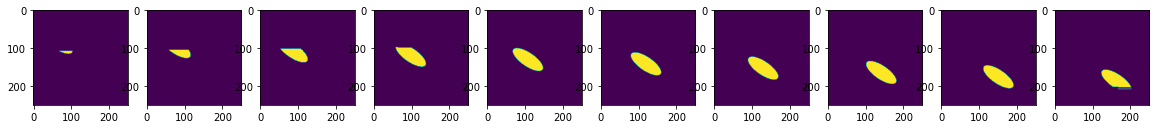

In [8]:
plot_slices_at_interval(10, 20, simulation, 'y')

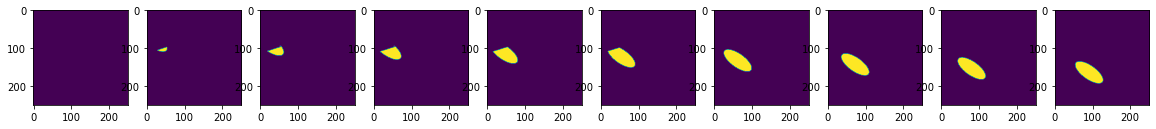

In [9]:
plot_slices_at_interval(10, 50, simulation, 'z')

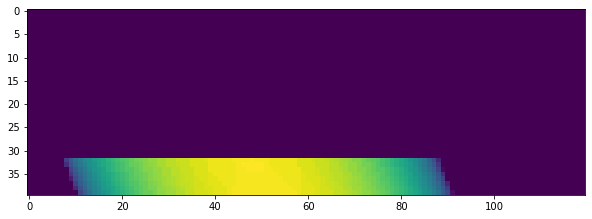

In [14]:
plt.figure(figsize = (10,10))
plt.imshow(simulation.density.sum(axis=2)[0:40,0:120])

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(simulation.density.sum(axis=2)[0:40,0:120])

the maximal difference between the implementation of the FTI is 0.010491851717233658


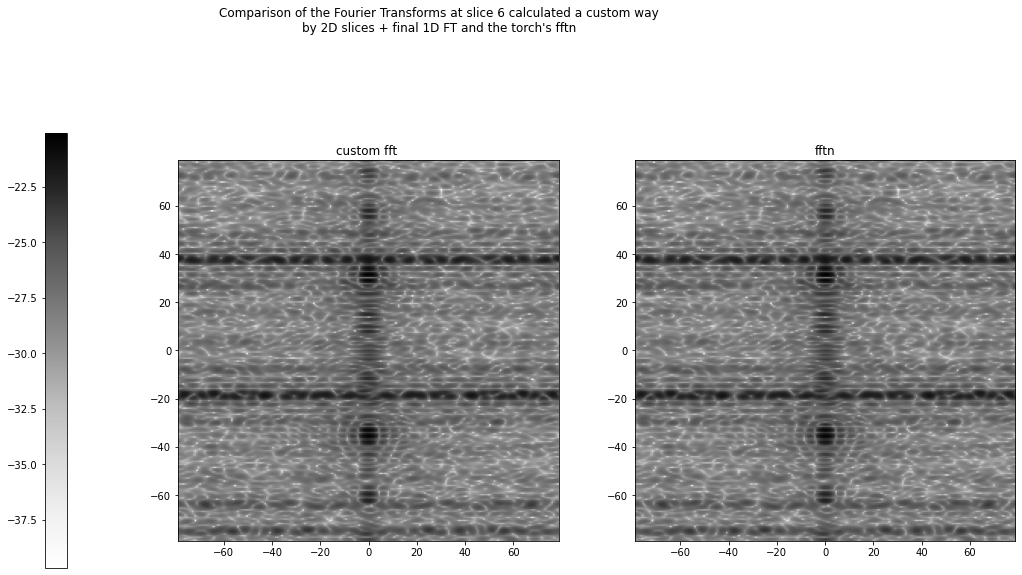

In [9]:
simulation.calculate_custom_FTI_3D(device = 'cpu')
simulation.calculate_torch_FTI_3D(device = 'cpu')
plot_FTI_version(simulation.FTI_custom, simulation.FTI_torch, simulation.qx)


In [10]:


def plt_slices_sim(simulation):
    fig,axs = plt.subplots(1,3,figsize = (15,5))
    ax = axs[0]
    im = ax.imshow(np.log(simulation.FTI_custom[120,:,:]), cmap = 'Greys')
    ax = axs[1]
    im = ax.imshow(np.log(simulation.FTI_custom[:,120,:]), cmap = 'Greys')
    ax = axs[2]
    im = ax.imshow(np.log(simulation.FTI_custom[:,:,120]), cmap = 'Greys')
    plt.show()    


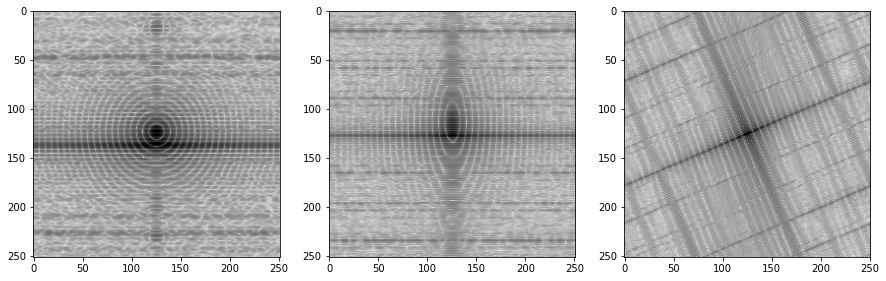

In [11]:
plt_slices_sim(simulation)

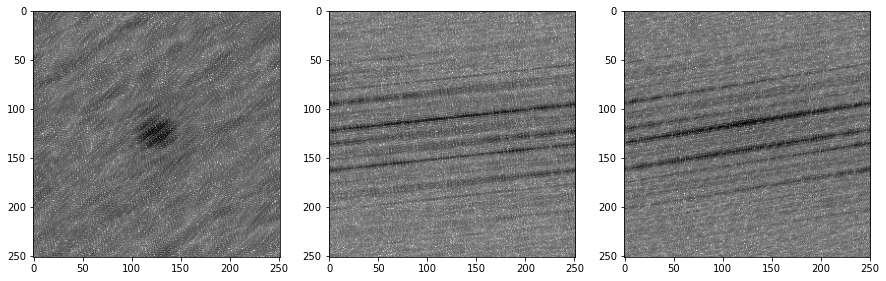

In [13]:
plt_slices_sim(simulation)

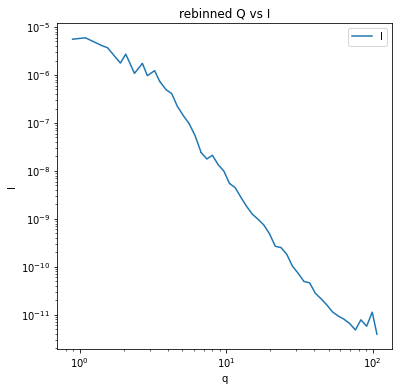

In [56]:

simulation.calculate_custom_FTI_3D_slice(device = 'cpu')
simulation.sinc()
simulation.reBin(200, slice = 'center')
simulation.drop_first_bin()
plot_Q_vs_I(simulation.binned_slice)

In [57]:
simulation.save_data(directory='dat_files')
print("the cylinder file with radius {r:.3f} and height {h:.3f} is saved".format(r = simulation.rMean, h = simulation.hMean))

the cylinder file with radius 0.360 and height 3.403 is saved


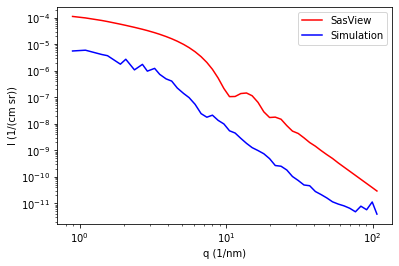

In [58]:
simulation.init_sas_model()
plot_simulation_vs_sas( simulation.binned_slice, simulation.qx_sas, simulation.I_sas)

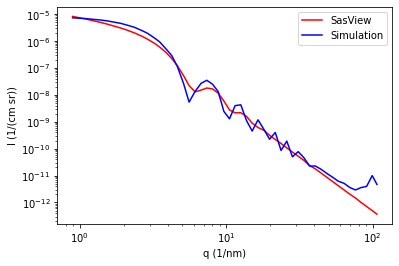

In [8]:

simulation.update_scaling(2.1625e-02)
plot_simulation_vs_sas( simulation.binned_slice, simulation.qx_sas, simulation.I_sas)

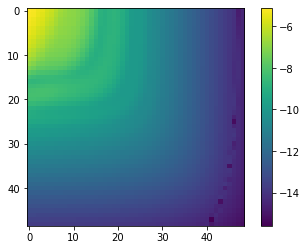

In [9]:
simulation.intensity_2d_sas()
plot_2d_sas(simulation.Intensity_2D_sas)

the maximal difference between the implementation of the FTI is 0.020193370059132576


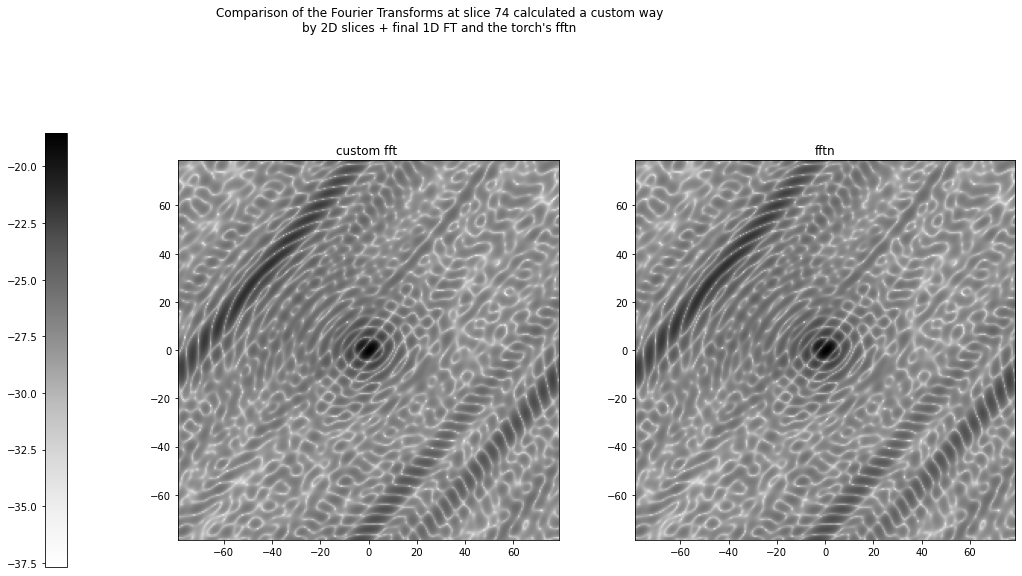

In [10]:

plot_FTI_version(simulation.FTI_custom, simulation.FTI_torch, simulation.qx)

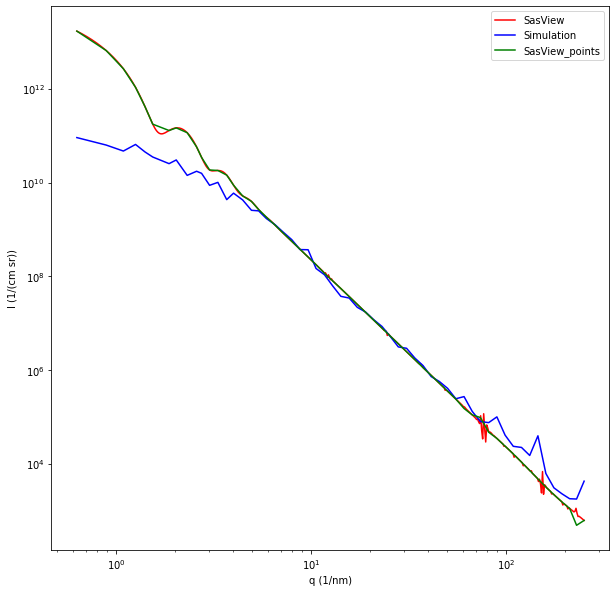

In [101]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
plt.plot(q, intensity, '-', color = 'red', label = 'SasView')
plt.plot(simulation.binned_data.Q, simulation.binned_data.I, color = 'blue', label = 'Simulation')
plt.plot(q1, intensity1, '-', color = 'green', label = 'SasView_points')
plt.xlabel("q (1/nm)")
plt.ylabel("I (1/(cm sr))")
plt.xscale('log') 
plt.yscale('log') 
plt.legend()
